In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [3]:
# df = pd.read_excel("../models/data/EsaveExportSmall.xls") # for github and small dataset
df = pd.read_excel("../../EsaveExportBig.xls") # local file. use above if not you are not me
df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
datetime = df.pop("datetime")
df = df.dropna(axis=1, how="any")
df = df.applymap(lambda cell: float(str(cell).replace(",", ".")))
channels = df.shape[1] # for later

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

-8.396527777777777


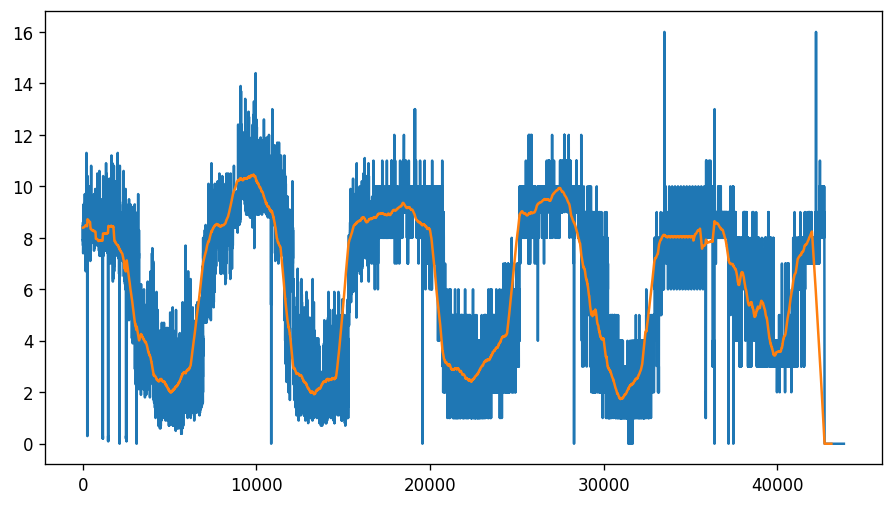

In [130]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

channel = 30
x = values[:,channel]
avgs = moving_average(x, 24*30)
print(avgs[-1] - avgs[0])
plt.plot(values[:,channel])
plt.plot(avgs)
plt.show()

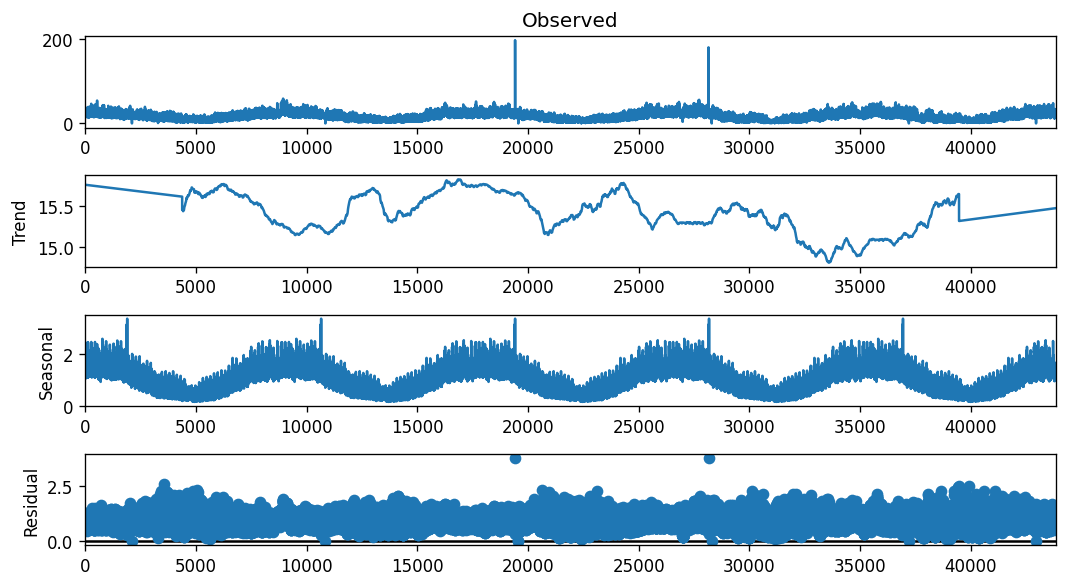

In [72]:
x[np.where(x == 0)] = 0.1
decomposition = sm.tsa.seasonal_decompose(x, model='multiplicative',extrapolate_trend='freq', period=24*365)
fig = decomposition.plot()
plt.show()

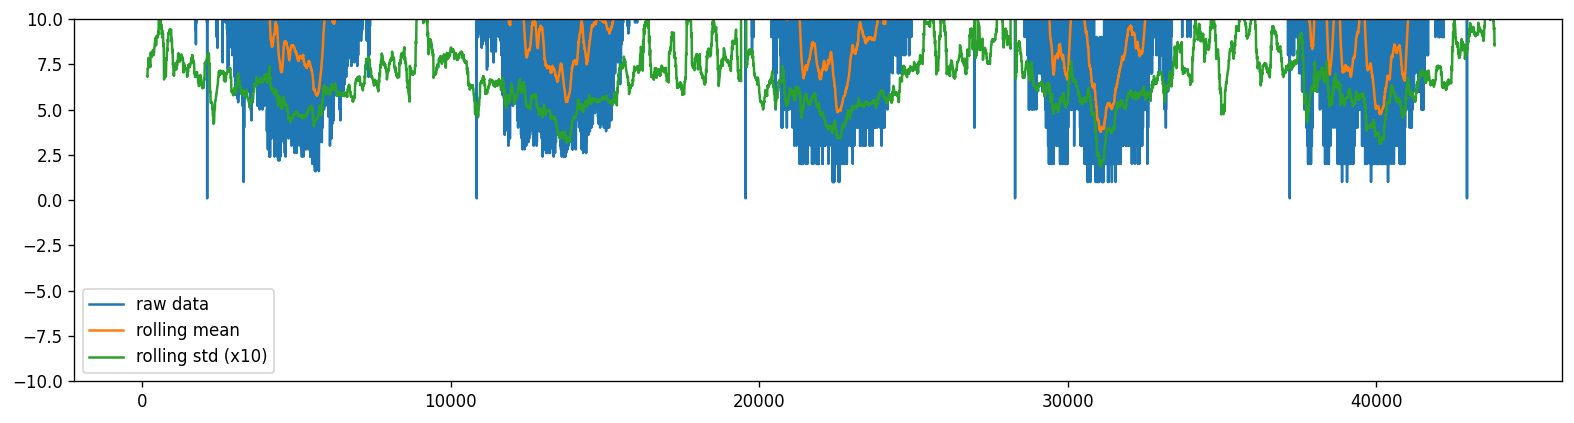

In [93]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=24*7).mean() 
    rolstd = pd.Series(timeseries).rolling(window=24*7).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.set_ylim(-10,10)
    ax.legend()
    
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
    
test_stationarity(x,'raw data')

In [131]:
x = pd.Series(x)
detrend = (x - x.rolling(window=24).mean())/x.rolling(window=24).std()
xlag =  x - x.shift(24)
both = detrend - detrend.shift(24)

ADF_test(x,'raw data')
print("\n")
ADF_test(detrend,'de-trended data')
print("\n")
ADF_test(xlag,'differenced data')
print("\n")
ADF_test(both,'de-trended + differenced data')

 > Is the raw data stationary ?
Test statistic = -4.477
P-value = 0.000
Critical values :
	1%: -3.430499321474984 - The data is  stationary with 99% confidence
	5%: -2.8616059968192618 - The data is  stationary with 95% confidence
	10%: -2.5668051279600483 - The data is  stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -32.416
P-value = 0.000
Critical values :
	1%: -3.4304994443243553 - The data is  stationary with 99% confidence
	5%: -2.861606051114624 - The data is  stationary with 95% confidence
	10%: -2.5668051568599415 - The data is  stationary with 90% confidence


 > Is the differenced data stationary ?
Test statistic = -31.555
P-value = 0.000
Critical values :
	1%: -3.4304994101792583 - The data is  stationary with 99% confidence
	5%: -2.8616060360236197 - The data is  stationary with 95% confidence
	10%: -2.5668051488274246 - The data is  stationary with 90% confidence


 > Is the de-trended + differenced data stationary ?
Test statistic

In [35]:
# ADF Test
result = adfuller(df.iloc[:,0], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')
    
# KPSS Test
result = kpss(df.iloc[:,0], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.960392547344375
p-value: 8.254689604820228e-15
Critial Values:
1%, -3.4304993351149395
Critial Values:
5%, -2.861606002847671
Critial Values:
10%, -2.566805131168801

KPSS Statistic: 0.440968
p-value: 0.059497
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


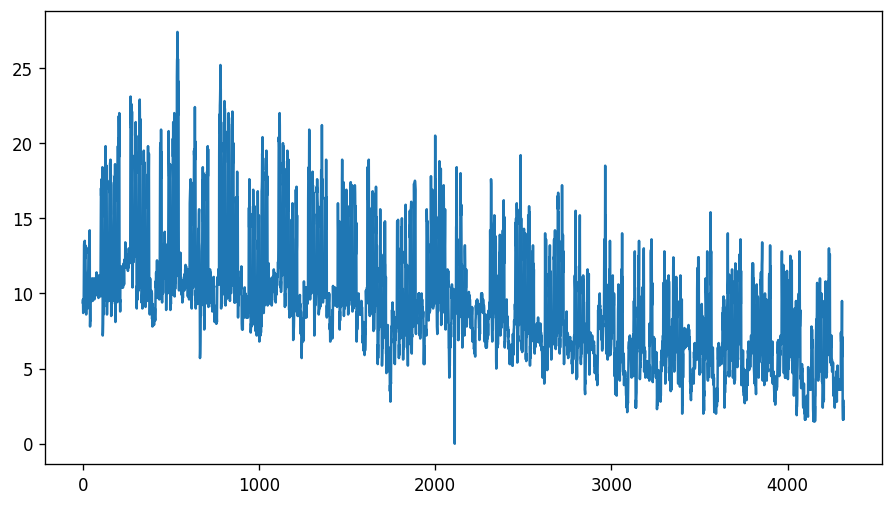

In [37]:
plt.plot(df.iloc[:24*180,0])
plt.show()

In [36]:
# ADF Test
result = adfuller(df.iloc[:24*180,0], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')
    
# KPSS Test
result = kpss(df.iloc[:24*180,0], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.605098465645003
p-value: 0.00012640331772780108
Critial Values:
1%, -3.431875937258768
Critial Values:
5%, -2.862214274623216
Critial Values:
10%, -2.567128921428161

KPSS Statistic: 8.444764
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
